In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size = 11, stride = 4, padding = 1), nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2),
    nn.Conv2d(96, 256, kernel_size = 5, padding = 2), nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2),
    nn.Conv2d(256, 384, kernel_size = 3, padding = 1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size = 3, padding = 1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size = 3, padding = 1), nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.Linear(4096, 10)
)
X = torch.rand(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape\t', X.shape)

Conv2d output shape	 torch.Size([1, 96, 54, 54])
ReLU output shape	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape	 torch.Size([1, 96, 26, 26])
Conv2d output shape	 torch.Size([1, 256, 26, 26])
ReLU output shape	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape	 torch.Size([1, 256, 12, 12])
Conv2d output shape	 torch.Size([1, 384, 12, 12])
ReLU output shape	 torch.Size([1, 384, 12, 12])
Conv2d output shape	 torch.Size([1, 384, 12, 12])
ReLU output shape	 torch.Size([1, 384, 12, 12])
Conv2d output shape	 torch.Size([1, 256, 12, 12])
ReLU output shape	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape	 torch.Size([1, 256, 5, 5])
Flatten output shape	 torch.Size([1, 6400])
Linear output shape	 torch.Size([1, 4096])
ReLU output shape	 torch.Size([1, 4096])
Dropout output shape	 torch.Size([1, 4096])
Linear output shape	 torch.Size([1, 4096])
ReLU output shape	 torch.Size([1, 4096])
Dropout output shape	 torch.Size([1, 4096])
Linear output shape	 torch.Size([1, 10])


(224- 11 + 1 + 2 )/ 4 = 54
(54 - 3 + 1) / 2 = 52

In [2]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

In [3]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a,b in zip(self.data, args)] # 逻辑：通过 zip 配对原有数据和新数据，逐个元素相加
 
    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
def accuracy(y_hat, y):
    y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device = None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print(device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(net(X), y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                                 (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
              f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
              f'on {str(device)}')

net.eval()	模型的层行为（如 Dropout、BatchNorm）	切换模型到 “评估模式”，关闭训练特有的层功能（如 Dropout 停止随机丢弃神经元，BatchNorm 使用训练时的滑动均值 / 方差）	模型评估、测试、预测时

with torch.no_grad():	代码块内的张量梯度计算	临时关闭梯度跟踪（不记录计算图，不计算梯度），节省内存和计算资源	推理、指标计算、参数查看时

X.to(device)	原 X 未变化，仍在原设备上	迁移后的新张量未被任何变量引用

loss 0.188, train acc 0.969, test acc 0.917
2150.4 examples/sec on cuda:0


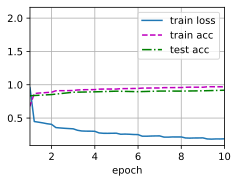

In [5]:
lr , num_epochs = 0.1, 10
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())